In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose, STL

from utils import get_figure, time_plot, moving_average_smoothing
from data import (
    get_electrocardiogram,
    get_switzerland_temperature,
    get_mauna_loa_co2,
    get_random_walk,
)


In [3]:
def mse(a, b):
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    mask = np.isfinite(a) & np.isfinite(b)
    return np.mean((a[mask] - b[mask])**2)

<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\s'
/var/folders/rs/65df6vr950918gkv11r91kmh0000gn/T/ipykernel_39523/1587551187.py:16: SyntaxWarning: invalid escape sequence '\s'
  label=f'$\sigma^2 = 9$, $u_t = 0.5$, seed = {seeds[0, 0]}',


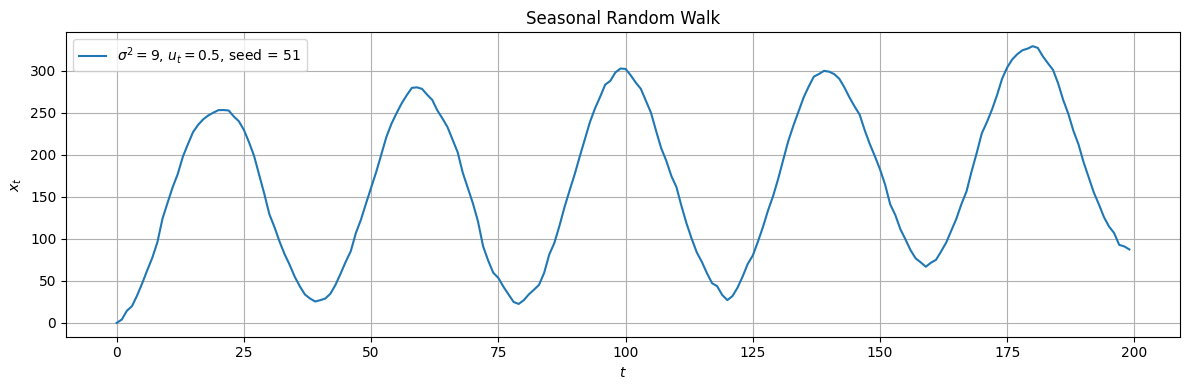

In [15]:
np.random.seed(42)
seeds = np.random.randint(0, 100, (2, 2))
n_steps = 200

# Multiple seasonal components
samples = np.arange(n_steps)
seasonal1 = 20 * np.sin(2 * np.pi * samples / 40)

fig, [ax] = get_figure()
formulae = [f"$u_t = 0.5$", "$u_t = -t/10$"]

rw1 = get_random_walk(seeds[0, 0], n_steps, variance=9, drift=0.5, seasonal=seasonal1)
time_plot(
    x=samples, 
    y=rw1, 
    label=f'$\sigma^2 = 9$, $u_t = 0.5$, seed = {seeds[0, 0]}',
    title='Seasonal Random Walk',
    ax=ax
)
fig.tight_layout()

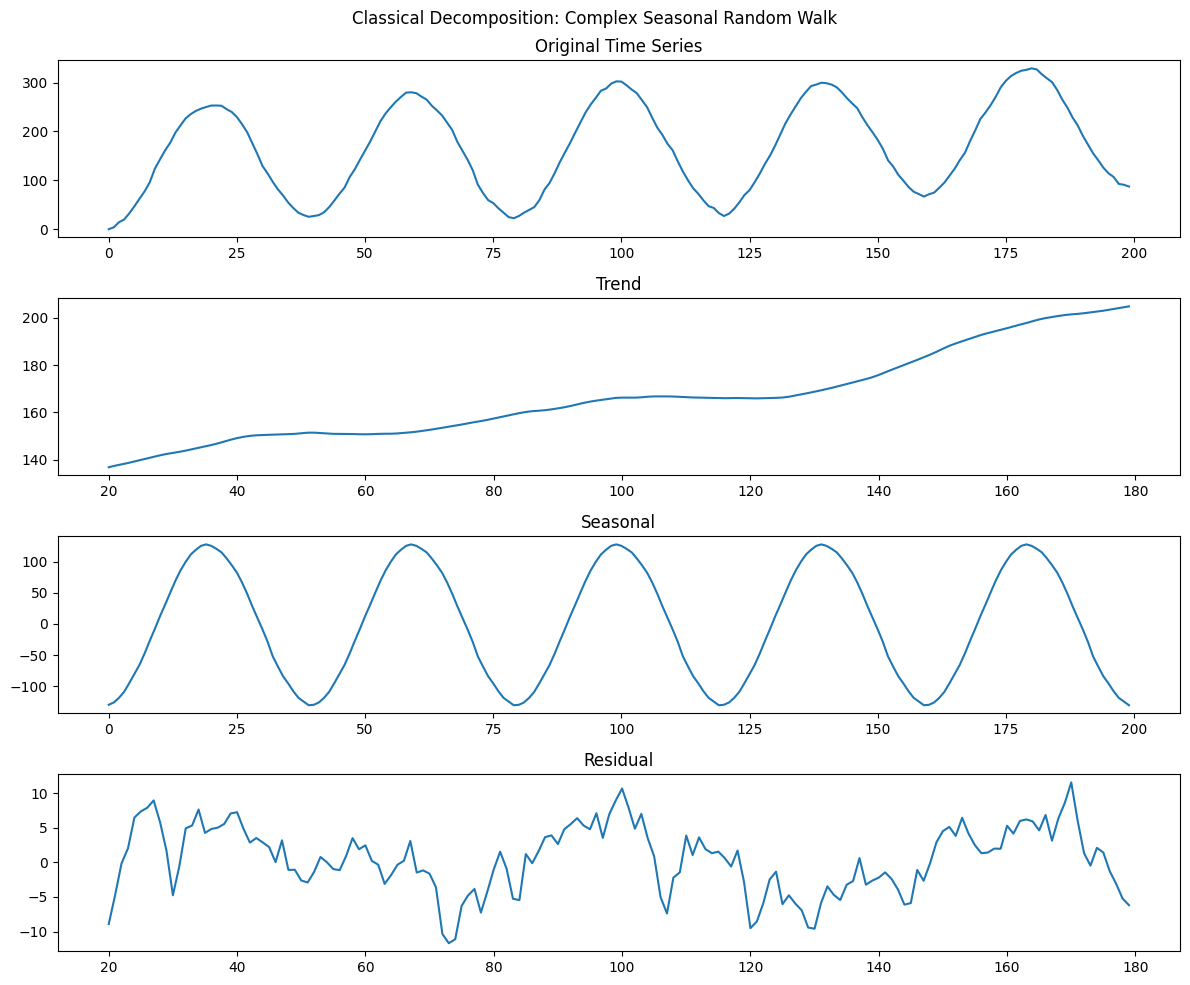

In [28]:
res1 = seasonal_decompose(rw1, period=40)  

# Plotting
fig, axs = plt.subplots(4, 1, figsize=(12, 10))

# Original time series
axs[0].plot(rw1)
axs[0].set_title('Original Time Series')

# Decomposition components
axs[1].plot(res1.trend)
axs[1].set_title('Trend')

axs[2].plot(res1.seasonal)
axs[2].set_title('Seasonal')

axs[3].plot(res1.resid)
axs[3].set_title('Residual')

fig.suptitle('Classical Decomposition: Complex Seasonal Random Walk')
fig.tight_layout()

The trend is smooth and accurately captures the long-term upward movement.
The seasonal component is extracted almost perfectly—its shape, amplitude, and timing match the true repeating pattern.
The residuals are small and mostly noise-like, showing that very little structure was left unexplained.

In [29]:
# Calculate MSE of residuals

mse = np.nanmean(res1.resid**2)
print("MSE of residuals:", mse)

MSE of residuals: 23.404792838188776


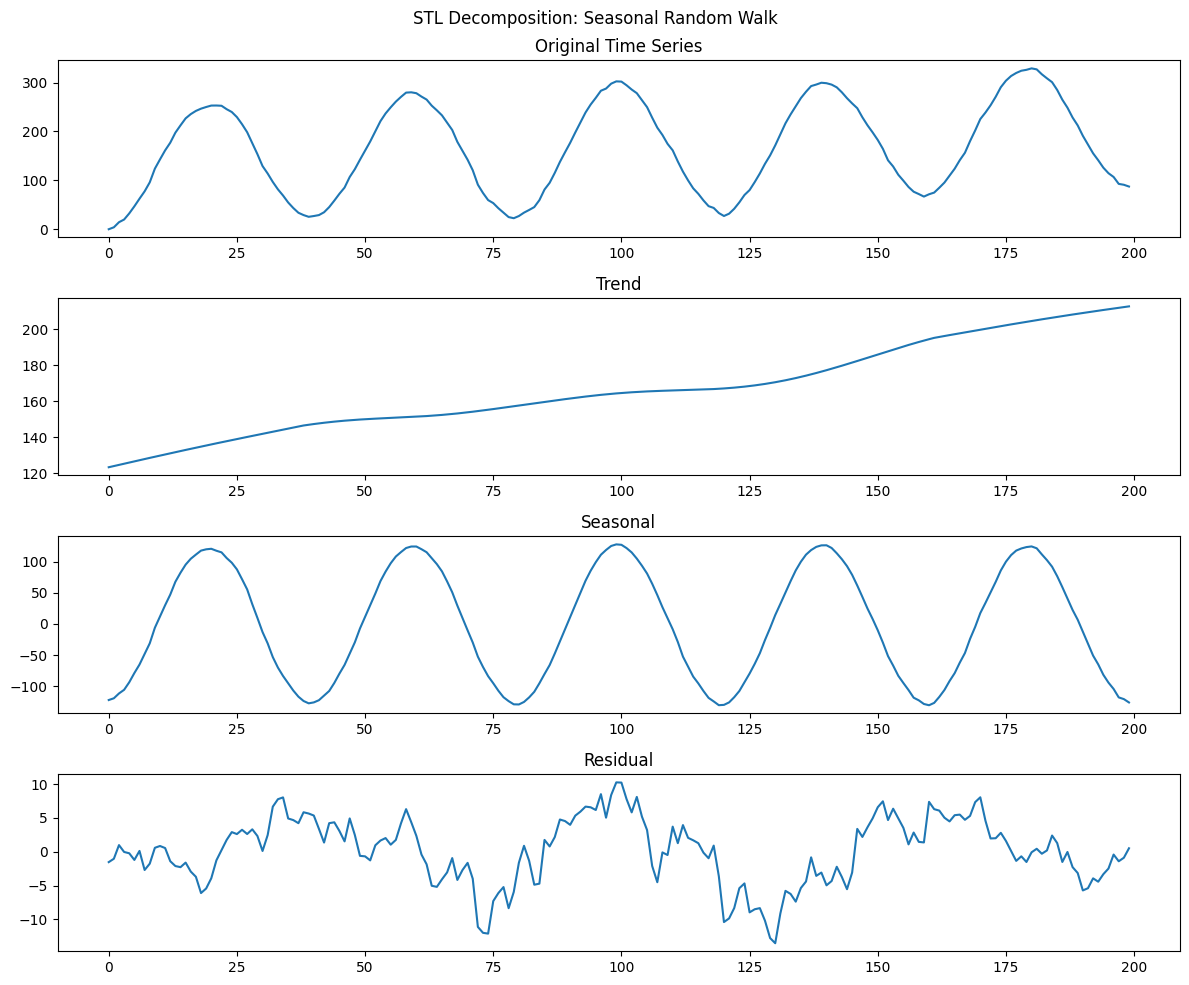

In [39]:
# STL decomposition

res1 = STL(rw1, period=40).fit()
fig, axs = plt.subplots(4, 1, figsize=(12, 10))

# Original time series
axs[0].plot(rw1)
axs[0].set_title('Original Time Series')

# Decomposition components
axs[1].plot(res1.trend)
axs[1].set_title('Trend')

axs[2].plot(res1.seasonal)
axs[2].set_title('Seasonal')

axs[3].plot(res1.resid)
axs[3].set_title('Residual')

fig.suptitle('STL Decomposition: Seasonal Random Walk')
fig.tight_layout()

The trend is smooth and captures the long-run upward movement clearly.
The seasonal component is extracted very good.
The residuals are small and mostly noise-like.

In [31]:
# Calculate MSE of residuals

mse = np.nanmean(res1.resid**2)
print("MSE of residuals:", mse)

MSE of residuals: 23.310786283886888


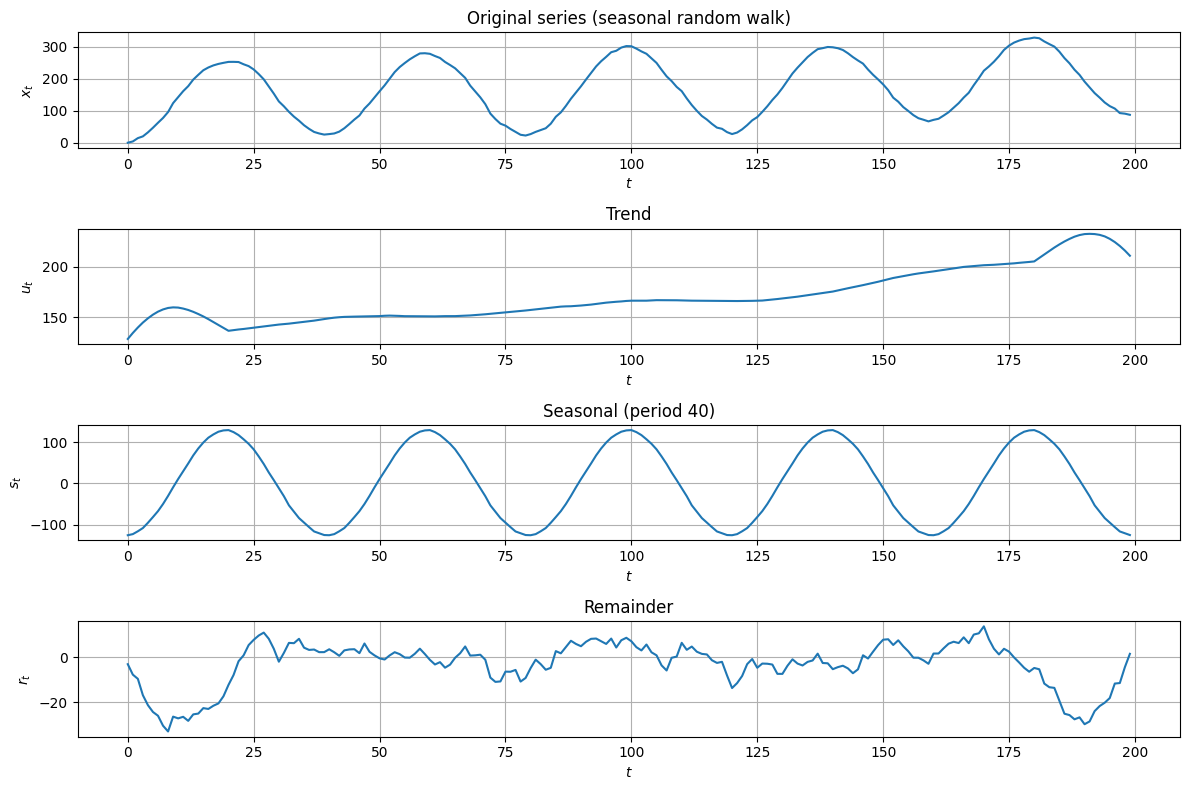

In [40]:
# reimplement classical decomposition

# Classical additive decomposition (P = 40)
period = 40

# Put series into a DataFrame
df = pd.DataFrame({"Series": rw1}, index=samples)

# Estimate trend with centered moving average over one full period
df["Trend"] = df["Series"].rolling(window=period, center=True, min_periods=1).mean()

# Detrend
df["Detrended"] = df["Series"] - df["Trend"]

# Estimate seasonal pattern by averaging detrended values by position in the period
df["Phase"] = df.index % period        
seasonal_pattern = df.groupby("Phase")["Detrended"].mean()

# Adjust seasonal pattern to have mean zero over one full period
seasonal_pattern_adj = seasonal_pattern - seasonal_pattern.mean()

# Map seasonal component back to each time point
df["Seasonal"] = df["Phase"].map(seasonal_pattern_adj)

# Remainder
df["Remainder"] = df["Series"] - df["Trend"] - df["Seasonal"]


# Plot: original + components
fig, (ax1, ax2, ax3, ax4) = get_figure(4, 1, figsize=(12, 8))

time_plot(
    x=df.index,
    y=df["Series"],
    title="Original series (seasonal random walk)",
    ax=ax1,
)

time_plot(
    x=df.index,
    y=df["Trend"],
    title="Trend",
    ax=ax2,
    ylabel="$u_t$",
)

time_plot(
    x=df.index,
    y=df["Seasonal"],
    title="Seasonal (period 40)",
    ax=ax3,
    ylabel="$s_t$",
)

time_plot(
    x=df.index,
    y=df["Remainder"],
    title="Remainder",
    ax=ax4,
    ylabel="$r_t$",
)

fig.tight_layout()


<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\s'
/var/folders/rs/65df6vr950918gkv11r91kmh0000gn/T/ipykernel_39523/3122125254.py:16: SyntaxWarning: invalid escape sequence '\s'
  label=f'$\sigma^2 = 16$, $u_t = 1$, seed = {seeds[1, 0]}',


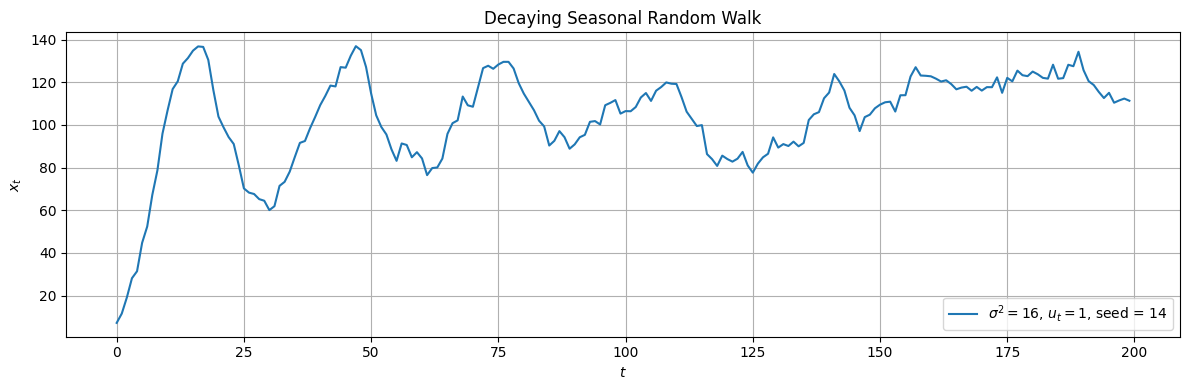

In [32]:
np.random.seed(42)
seeds = np.random.randint(0, 100, (2, 2))
n_steps = 200

# Seasonal component with exponential decay
samples = np.arange(n_steps)
seasonal2 = 15 * np.exp(-0.02 * samples) * np.sin(2 * np.pi * samples / 30)

fig, [ax] = get_figure()
formulae = [f"$u_t = 1$", "$u_t = -t/20$"]

rw2 = get_random_walk(seeds[1, 0], n_steps, variance=16, drift=1, seasonal=seasonal2)
time_plot(
    x=samples, 
    y=rw2, 
    label=f'$\sigma^2 = 16$, $u_t = 1$, seed = {seeds[1, 0]}',
    title='Decaying Seasonal Random Walk',
    ax=ax
)
fig.tight_layout()

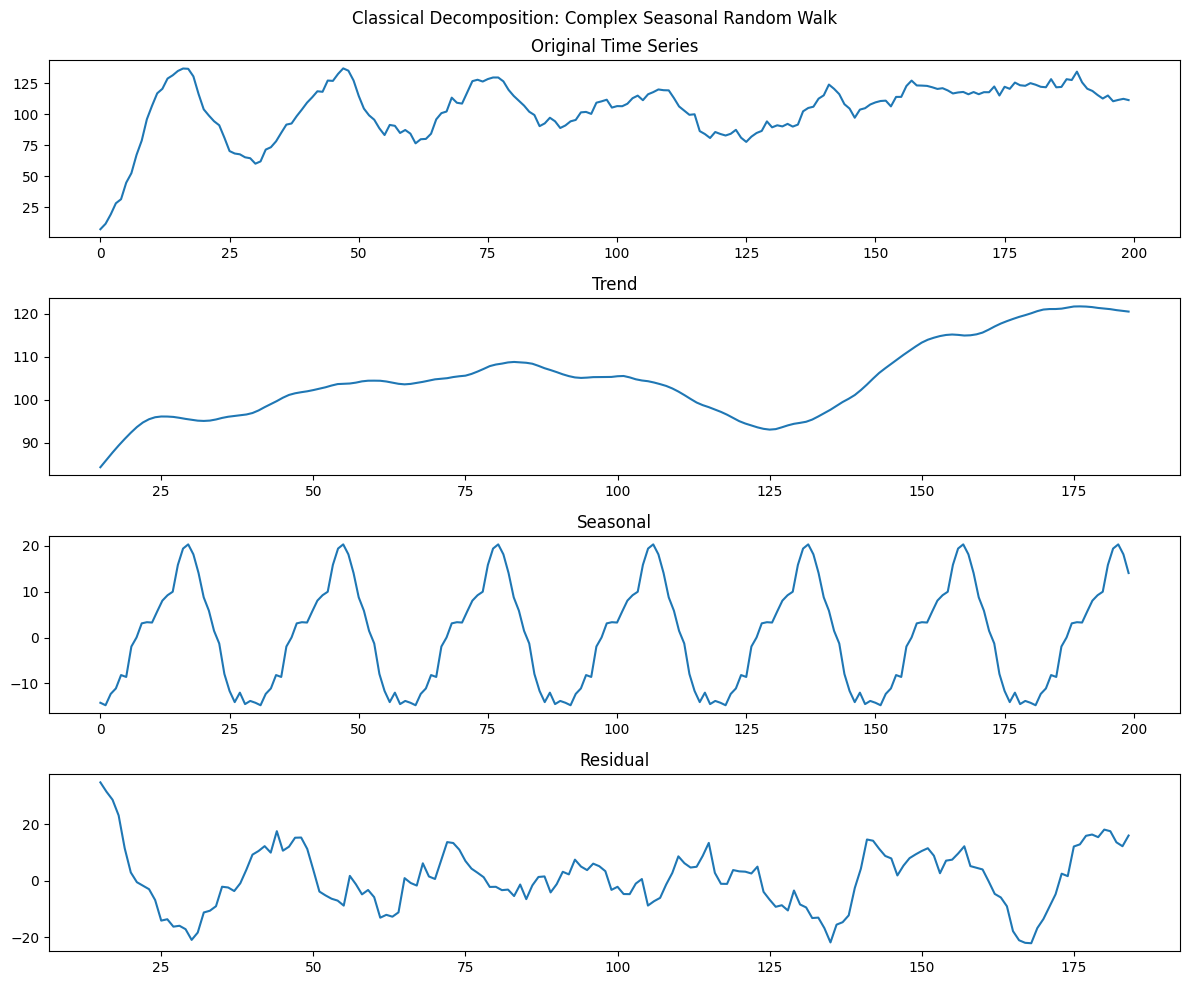

In [33]:
res2 = seasonal_decompose(rw2, period=30)

# Plotting
fig, axs = plt.subplots(4, 1, figsize=(12, 10))

# Original time series
axs[0].plot(rw2)
axs[0].set_title('Original Time Series')

# Decomposition components
axs[1].plot(res2.trend)
axs[1].set_title('Trend')

axs[2].plot(res2.seasonal)
axs[2].set_title('Seasonal')

axs[3].plot(res2.resid)
axs[3].set_title('Residual')

fig.suptitle('Classical Decomposition: Complex Seasonal Random Walk')
fig.tight_layout()

The trend isn't a straight line but shows the upward trajectory (most of the time).
The seasonal component is fixed (by design) and does not adapt to decreasing.
The residual shows significant leftover structure, especially early in the series.

In [34]:
# Calculate MSE of residuals

mse = np.nanmean(res2.resid**2)
print("MSE of residuals:", mse)

MSE of residuals: 111.12697593154105


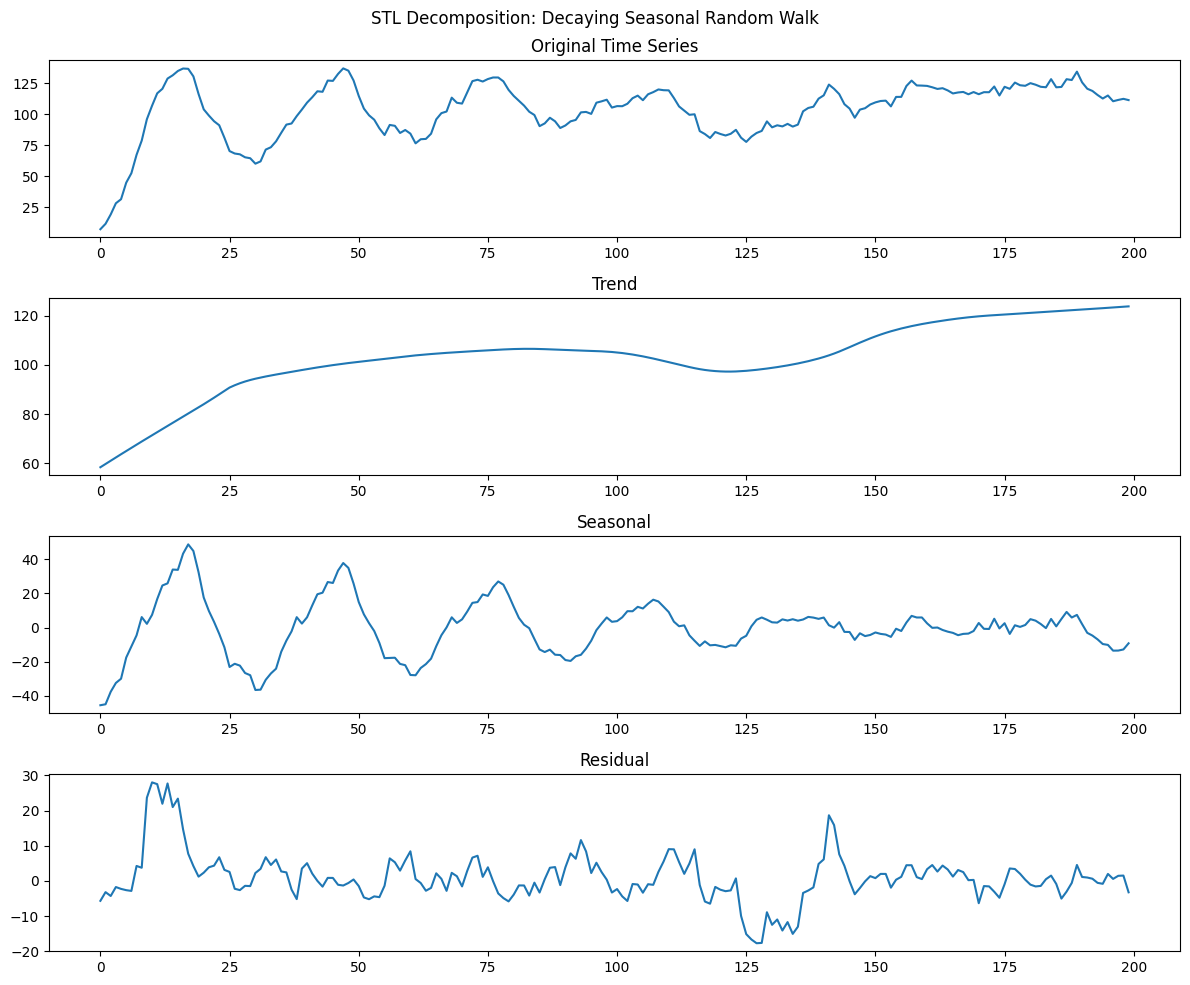

In [35]:
# STL Decomposition
res2 = STL(rw2, 
           period=30,     
           seasonal=13,   
           robust=True    
          ).fit()

fig, axs = plt.subplots(4, 1, figsize=(12, 10))

# Original time series
axs[0].plot(rw2)
axs[0].set_title('Original Time Series')

# Decomposition components
axs[1].plot(res2.trend)
axs[1].set_title('Trend')

axs[2].plot(res2.seasonal)
axs[2].set_title('Seasonal')

axs[3].plot(res2.resid)
axs[3].set_title('Residual')

fig.suptitle('STL Decomposition: Decaying Seasonal Random Walk')
fig.tight_layout()

Review: Trend: Captures the overall upward trajectory, Shows slight curvature, not just a straight line
Seasonal: Seasonality extracted well early.
Residual: Leftover seasonal structure in late periods. Not pure white noise.

In [36]:
# Calculate MSE of residuals

mse = np.nanmean(res2.resid**2)
print("MSE of residuals:", mse)

MSE of residuals: 49.906392457596056


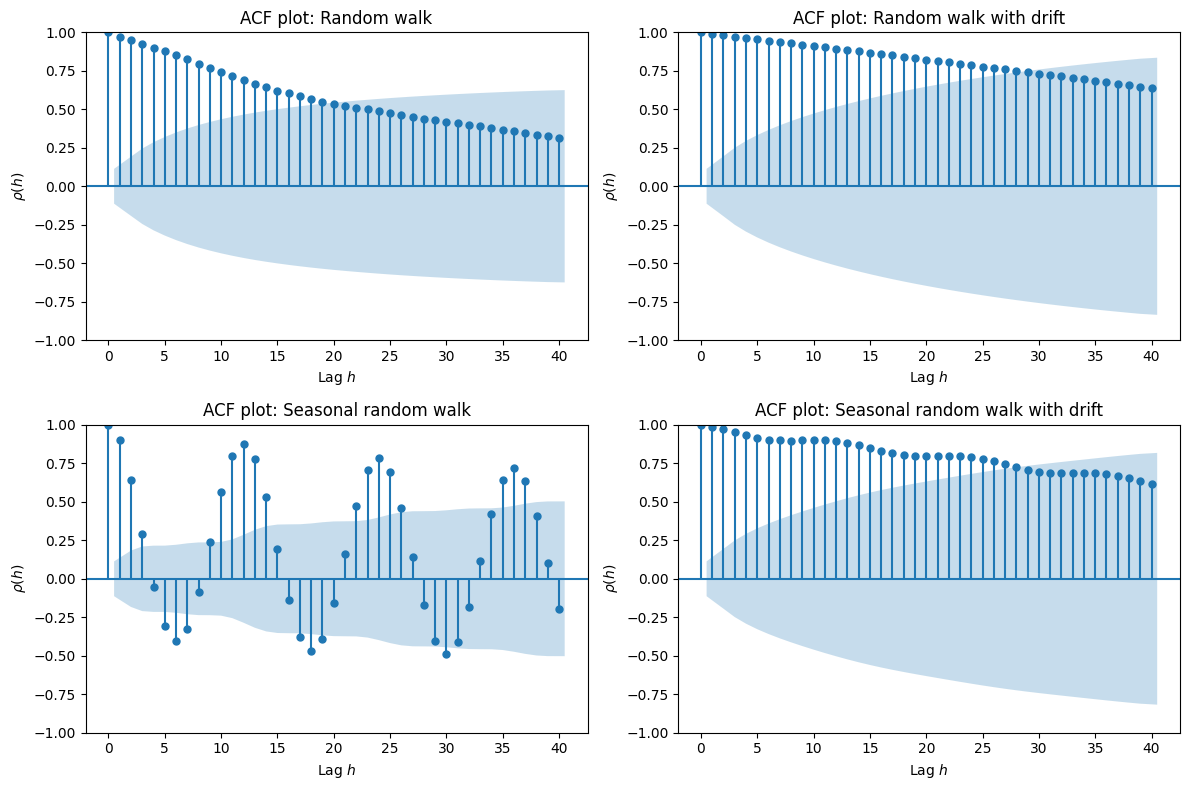

In [38]:

# generate random-walk 
def random_walk(innov, drift=None, seasonal=None):
    x = np.zeros_like(innov)
    for t in range(1, len(innov)):
        d = drift[t] if drift is not None else 0
        s = seasonal[t] if seasonal is not None else 0
        x[t] = x[t-1] + innov[t] + d + s
    return x

np.random.seed(42)
n = 300
sigma = 1.0

# white-noise 
w = np.random.normal(0, sigma, size=n)

# drift
mu = 0.5
drift_series = np.full(n, mu)

# seasonality
A = 5.0
P = 12
t = np.arange(n)
seasonal_series = A * np.sin(2 * np.pi * t / P)

# four series
rw = random_walk(w)
rw_drift = random_walk(w, drift=drift_series)
seasonal_rw = random_walk(w, seasonal=seasonal_series)
seasonal_rw_drift = random_walk(w, drift=drift_series, seasonal=seasonal_series)


# Plot ACFs

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

acf_plot(rw, 40, axes[0, 0], "Random walk")
acf_plot(rw_drift, 40, axes[0, 1], "Random walk with drift")
acf_plot(seasonal_rw, 40, axes[1, 0], "Seasonal random walk")
acf_plot(seasonal_rw_drift, 40, axes[1, 1], "Seasonal random walk with drift")

plt.tight_layout()
plt.show()


Random walk (top-left): Starts at 1 and decays slowly and smoothly. Always positive, decreasing roughly linearly.

Random walk with drift (top-right): Very similar to the plain random walk, but decays even more slowly and stays closer to 1.

Seasonal random walk (bottom-left): Clear oscillation: big positive spikes around lags (12, 24, 36) and also negative values in between. wave-like / sinusoidal behaviour

Seasonal random walk with drift: Slow decay, with high positive values overall.
Trend (drift) that contributes to persistent positive correlations.
Small waves from Seasonality (repeating peaks at seasonal lags).